# Experiments with a Perceptron Model

TO DO: Write a note summarizing the experiment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import math

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) #Set default plot sizes
plt.rcParams['image.interpolation'] = 'nearest' #Use nearest neighbor for rendering

In [3]:
# Allowing notebooks to reload external python modules
# Details: http://stackoverflow.com/questions/1907993/aut
%load_ext autoreload
%autoreload 2

## Data Set
For this simple example, I will use a handcrafted dataset. The dataset is generated from the equation e^(0.3*x1 + 0.6*x2 + 0.5). Values above 3.0 are marked as belonging to class 1 and below 3.0 are marked as belonging to class 0.

In [4]:
#here is an artificial dataset
x1 = np.array(np.arange(0.1,0.7,0.1))
print("x1:", np.exp(x1*0.3))
x2 = np.array(np.arange(0.6,1.1,0.1))
print("x2:", np.exp(x2*0.6))

#e^(W11*x1 + W12*x2 + B1)
print("Exponentiated values:", np.exp(0.3*x1 + 0.6*x2 + 0.5))

#From the output, lets use 3 as threshold; Value>3 = class 1, value<3 = class 0
Y = np.array([0,0,0,1,1,1])
X = np.array([x1,x2])

x1: [ 1.03045453  1.06183655  1.09417428  1.12749685  1.16183424  1.19721736]
x2: [ 1.43332941  1.52196156  1.6160744   1.71600686  1.8221188   1.93479233]
Exponentiated values: [ 2.43512965  2.66445624  2.9153795   3.18993328  3.49034296  3.81904351]


### Sigmoid Function

Exponential values for moderately large numbers tend to overflow. So np.clip is used here to limit the values of the signal between -500 and 500. Since e^x is between 0 and 1, the error in using this clip is low.Additionally, here I am using a numerically stable version of sigmoid function
Note that we can write 
$\frac{1}{1+e^-z}$ as $\frac{e^z}{1+e^z}$

In [5]:
import numpy as np
def sigmoid(x):
    x = np.clip(x, -500,500)
    if x.any()>=0:
        return 1/(1+ np.exp(-x))
    else:
        return np.exp(x)/(1 + np.exp(x))

### Initialize Parameters

In [6]:
def init_parameters(dim1, dim2=1,std=1e-1, random = True):
    if(random):
        return(np.random.random([dim1,dim2])*std)
    else:
        return(np.zeros([dim1,dim2]))

### Forward Propogation

Here, I am assuming a single layered network. Note that event with single layered network, the layer itself can have multiple nodes. Also, I am using vectorized operations here i.e not using explicit loops. This helps in processing multiple inputs.

In [7]:
#Single layer network: Forward Prop
def fwd_prop(W1,B1,X,Y):
    n_0 = np.shape(X)[0]
    m   = np.shape(X)[1]
    n_1 = np.shape(W1)[0]     
    
    #Dimensions
    # X = (n_0,m)
    # W1 = (n_1,n_0)
    # B1 = (n_1,1) -> Broadcast -> (n_1,m)
    # Z1 = (n_1,m)
    # A1 = (n_1,m)
    Z1 = np.dot(W1,X) + B1#
    A1 = sigmoid(Z1)
    #print("A1 shape", np.shape(A1))
    return(A1)

### Backpropagation

Here I am calculating the loss/cost. The loss function here is a logistic loss function and in this case of binary classification, this is also a cross-entropy loss

Cross Entropy loss for a single datapoint = $\sum_{i=1}^{c} y_i*log (\hat y_i) $
For binary classification: $y_i*log (\hat y_i) + (1-y_i)*log(1-\hat y_i) $

Lastly, the gradients w.r.t W1 and B1 are calculated and returned along with the total cost/loss

TO DO: Derive Backprop equation

In [17]:
#Single layer network: Backprop

def back_prop(A1,W1,B1,X,Y):
    n_0 = np.shape(X)[0]
    m   = np.shape(X)[1]
    n_1 = np.shape(W1)[0]
    
    
    cost = (-1/m)*np.sum(Y*np.log(A1) + (1-Y)*np.log(1-A1))
    #shape(dA1) = shape(A1) = (n_1,m)
    dA1 = -Y/A1 + (1-Y)/(1-A1)
    
    #shape(dZ1) = shape(Z1) = (n_1,m)
    dZ1 = (1/m)*(A1 - Y)
    
    #shape(dW1) = shape(W1) = (n_1,n_0)
    dW1 = np.dot(dZ1, X.T) # dZ1 = (n_1,m), X ->(n_0,m)
    
    #shape(dB1) = shape(B1) = (n_1,1)
    dB1 = np.sum(dZ1, axis = 1, keepdims = True)
    
    grads ={"dW1": dW1, "dB1":dB1}
    
    return(grads,cost)

### Gradient Descent

This function performs a simple gradient descent. After completing a round of forward propagation and backward propagation, the weights are updated based on the learning rate and gradient. The loss for that iteration is recorded in the loss_array. The function returns the final parameters W1,B1 and the loss array after running for given number of iterations

In [9]:
def run_grad_desc(num_iterations, learning_rate,X,Y,n_1):
    n_0, m = np.shape(X)
    
    W1 = init_parameters(n_1, n_0, random= False)
    B1 = init_parameters(n_1,1, random = False)
    
    loss_array = np.ones([num_iterations])*np.nan
    for i in np.arange(num_iterations):
        A1 = fwd_prop(W1,B1,X,Y)
        grads,cost = back_prop(A1,W1,B1,X,Y)
        
        W1 = W1 - learning_rate*grads["dW1"]
        B1 = B1 - learning_rate*grads["dB1"]
        
        loss_array[i] = cost
        
        parameter = {"W1":W1,"B1":B1}
    
    return(parameter,loss_array)

### Running the Experiment
All the helper functions have been created and now I am just running gradient descent on the handcrafted dataset that I had created earlier. Note that I am using n_1 = 1, therefore, I am just using one node. This is equivalent to logistic regression.

In [21]:
params, loss_array = run_grad_desc(100000,0.001,X,Y,n_1= 1 )
#print(loss_array)
print(params)

{'B1': array([[ 3.44835516]]), 'W1': array([[-3.75759556, -3.88372978]])}


Note that the dataset is generated from the equation e^(0.3*x1 + 0.6*x2 + 0.5). Values above 3.0 are marked as belonging to class 1 and below 3.0 are marked as belonging to class 0. The values generated after running the algorithm do not necessarily match to the weights we used in generating the data i.e 0.3, 0.6 and bias of 0.5. However, if we look multiple the weights with the input data we get the following output array

In [22]:
X[0]*params["W1"][0][0]* X[1]*params["W1"][0][1] + params["B1"][0]

array([  3.64098917,   3.52132258,   3.68914767,  13.95566493,
        13.95566493,  15.23259494])

Here there is  boundary of separation between 1st 3 values and last 3 values. 

Key thing to note here is that the data we generated was a linearly separable data and hence there are many possible options for the separting plane. Unlike SVM, logistic regression does not necessarily find the best separting plane, but finds a locally optimum solution that separates the classes of data

### Plot of the loss array
Here we want to ensure that the loss value per iteration is going down. However, note that the plot has not curved to reach stablizing value i.e we can run the algorithms more times to get a lower loss. However, this is not needed as the current value of the parameters can classify the input data accurately.

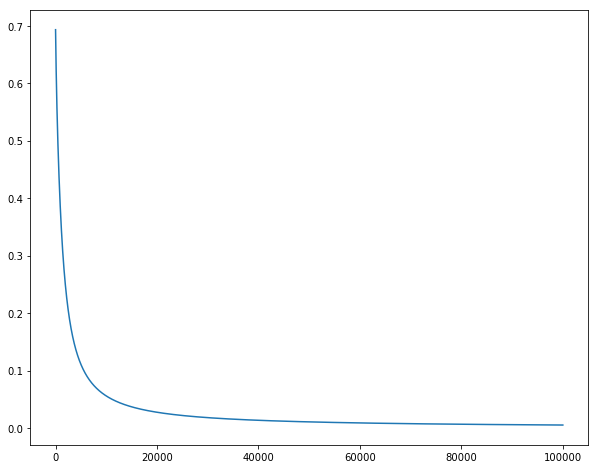

In [20]:
plt.plot(loss_array)

### Another example with handcrafted dataset

In [13]:
X = np.array([[0.25,0.75],[0.1,0.9],[0.3,0.8],[0.8,0.25],[0.9,0.2],[0.7,0.1]])
X = np.array([[0.11,0.12],[0.05,0.1],[0.15,0.11],[0.8,0.9],[0.9,0.8],[0.85,0.95]])
X = X.T #Had to do this because, I did not declare the X array as (#dimension * # Datapoints)
Y = np.array([1,1,1,0,0,0])
params, loss_array = run_grad_desc(100,0.01,X,Y,n_1= 1 )
#print(loss_array)
X[0]*params["W1"][0][0]* X[1]*params["W1"][0][1] + params["B1"][0]


array([ 0.00063367,  0.00062571,  0.00063688,  0.00132048,  0.00132048,
        0.00140551])